In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall networkx
!pip install networkx==2.7
!pip install scipy==1.8.1

In [2]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2022
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GATLayer(nn.Module):
    """GAT layer"""
    def __init__(self, n_feat, n_hidden, alpha=0.05):
        super(GATLayer, self).__init__()
        self.fc = nn.Linear(n_feat, n_hidden, bias=False)
        self.a = nn.Linear(2*n_hidden, 1)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, x, adj):
        
        ############## Task 1
    
        ##################
        # your code here #
        z = self.fc(x)
        indices = adj.coalesce().indices()
        h = torch.cat((z[indices[0,:],:], z[indices[1,:],:]), dim=1)
        h = self.a(h)
        h = self.leakyrelu(h)
        ##################

        h = torch.exp(h.squeeze())
        unique = torch.unique(indices[0,:])
        t = torch.zeros(unique.size(0), device=x.device)
        h_sum = t.scatter_add(0, indices[0,:], h)
        h_norm = torch.gather(h_sum, 0, indices[0,:])
        alpha = torch.div(h, h_norm)
        adj_att = torch.sparse.FloatTensor(indices, alpha, torch.Size([x.size(0), x.size(0)])).to(x.device)
        
        ##################
        # your code here #
        out = torch.sparse.mm(adj_att, z)
        ##################

        return out, alpha


class GNN(nn.Module):
    """GNN model"""
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GNN, self).__init__()
        self.mp1 = GATLayer(nfeat, nhid)
        self.mp2 = GATLayer(nhid, nhid)
        self.fc = nn.Linear(nhid, nclass)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj):
        
        ############## Tasks 2 and 4
    
        ##################
        # your code here #
        #1
        z1, alpha = self.mp1(x, adj)
        z1 = self.relu(z1)
        z1 = self.dropout(z1)

        #2
        z2, alpha = self.mp2(z1, adj)
        z2 = self.relu(z2)

        x = self.fc(z2)
        ##################

        return F.log_softmax(x, dim=1), alpha

In [3]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2022
"""

import numpy as np
import torch

def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

Number of nodes: 34
Number of edges: 78


<ipython-input-6-91fb831bdf31>:54: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G) # your code here #


Epoch: 001 loss_train: 0.6989 acc_train: 0.2222 time: 0.2221s
Epoch: 002 loss_train: 0.6848 acc_train: 0.5556 time: 0.0081s
Epoch: 003 loss_train: 0.6712 acc_train: 0.5926 time: 0.0081s
Epoch: 004 loss_train: 0.6618 acc_train: 0.5556 time: 0.0073s
Epoch: 005 loss_train: 0.6450 acc_train: 0.5556 time: 0.0066s
Epoch: 006 loss_train: 0.6382 acc_train: 0.5556 time: 0.0499s
Epoch: 007 loss_train: 0.6196 acc_train: 0.5556 time: 0.0278s
Epoch: 008 loss_train: 0.5929 acc_train: 0.5556 time: 0.0217s
Epoch: 009 loss_train: 0.5834 acc_train: 0.5556 time: 0.0104s
Epoch: 010 loss_train: 0.5661 acc_train: 0.5556 time: 0.0093s
Epoch: 011 loss_train: 0.5437 acc_train: 0.7037 time: 0.0100s
Epoch: 012 loss_train: 0.5116 acc_train: 0.7037 time: 0.0111s
Epoch: 013 loss_train: 0.4973 acc_train: 0.7037 time: 0.0078s
Epoch: 014 loss_train: 0.4824 acc_train: 0.7037 time: 0.0083s
Epoch: 015 loss_train: 0.4573 acc_train: 0.7037 time: 0.0083s
Epoch: 016 loss_train: 0.4480 acc_train: 0.7037 time: 0.0081s
Epoch: 0

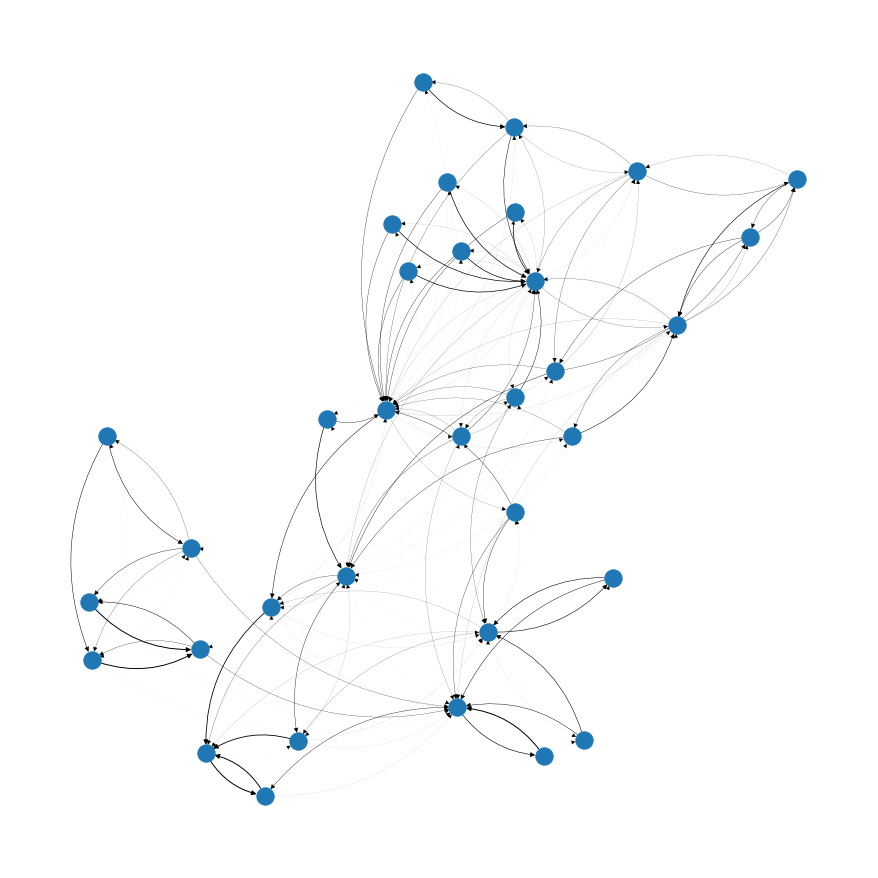

In [6]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2022
"""

import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# from models import GNN
# from utils import sparse_to_torch_sparse


# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
n_hidden = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('/content/drive/MyDrive/MVA/ALTEGRAD/rendu/Lab6_GALAGAIN_Calvin/code/data/karate.edgelist', 
                              delimiter=' ', 
                              nodetype=int, 
                              create_using=nx.Graph())
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('/content/drive/MyDrive/MVA/ALTEGRAD/rendu/Lab6_GALAGAIN_Calvin/code/data/karate_labels.txt', 
                          delimiter=',', 
                          dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

############## Task 3
adj = nx.adjacency_matrix(G) # your code here #
features = np.random.randn(n, 4) # your code here #

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, alpha = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))

print("Optimization Finished!")

# Testing
model.eval()
output, alpha = model(features, adj)
loss_test = F.nll_loss(output[idx_test], y[idx_test])
acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test))


############## Task 4
alpha = alpha.detach().cpu().numpy()# your code here #

# Dictionary that maps indices of nodes to nodes
idx_to_node = dict()
for i,node in enumerate(G.nodes()):
    idx_to_node[i] = node

# Creates a directed karate network
G_directed = G.to_directed()

# Retrieves nonzero indices of the adjacency matrix
indices = adj.coalesce().indices().detach().cpu().numpy()

# Annotates edges with the learned attention weights 
for i in range(indices.shape[1]):
    G_directed[idx_to_node[indices[0,i]]][idx_to_node[indices[1,i]]]['weight'] = alpha[i]

weights = [G_directed[u][v]['weight'] for u,v in G_directed.edges()]

# Visualizes attention weights
plt.figure(1,figsize=(12,12))
pos = nx.spring_layout(G_directed)
arc_rad = 0.25
nx.draw(G_directed, width=weights, connectionstyle=f'arc3, rad = {arc_rad}')
plt.show()

In [7]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2022
"""

import networkx as nx
import numpy as np
import torch
from random import randint

def create_dataset():
    Gs = list()
    y = list()

    ############## Task 5
    
    ##################
    # your code here #
    for i in range(50):
      Gs.append(nx.fast_gnp_random_graph(randint(10, 20), 0.2))
      Gs.append(nx.fast_gnp_random_graph(randint(10, 20), 0.4))
      y += [0, 1]
    ##################

    return Gs, y


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [8]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2022
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, n_class, device):
        super(GNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, n_class)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, idx):
        
        ############## Task 6
    
        ##################
        # your code here #

        adj = torch.eye(len(adj)) + adj

        x=self.fc1(x_in)
        x=self.relu(torch.mm(adj,x))
        x=self.fc2(x)
        ##################
        
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1)).to(self.device)
        out = out.scatter_add_(0, idx, x) 
        
        ##################
        # your code here #
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        ##################

        return F.log_softmax(out, dim=1)

In [9]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2022
"""

import time
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim

# from models import GNN
# from utils import create_dataset, sparse_mx_to_torch_sparse_tensor

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
batch_size = 8
n_hidden_1 = 16
n_hidden_2 = 32
n_hidden_3 = 32
learning_rate = 0.01

# Generates synthetic dataset
Gs, y = create_dataset()
n_class = np.unique(y).size

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

N_train = len(G_train)
N_test = len(G_test)

# Initializes model and optimizer
model = GNN(1, n_hidden_1, n_hidden_2, n_hidden_3, n_class, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    
    train_loss = 0
    correct = 0
    count = 0
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        idx_batch = list()
        y_batch = list()

        ############## Task 7
        
        ##################
        # your code here #
        for j in range(i, min(i+batch_size, N_train)):
          val_train = G_train[j]
          adj_batch.append(nx.adjacency_matrix(val_train))
          idx_batch += [j-i]*val_train.number_of_nodes()
        
        adj_batch = sparse_mx_to_torch_sparse_tensor(sp.block_diag(adj_batch))
        features_batch = torch.FloatTensor(np.ones((len(idx_batch), 1)))
        idx_batch = torch.LongTensor(idx_batch)
        y_batch = torch.LongTensor(y_train[i:min(i+batch_size, N_train)])
        ##################
        
        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
print('Optimization finished!')

# Evaluates the model
model.eval()
test_loss = 0
correct = 0
count = 0
for i in range(0, N_test, batch_size):
    adj_batch = list()
    idx_batch = list()
    y_batch = list()

    ############## Task 7
    
    ##################
    # your code here #
    for j in range(i, min(i+batch_size, N_test)):
      val_test = G_test[j]
      adj_batch.append(nx.adjacency_matrix(val_test))
      idx_batch += [j-i]*val_test.number_of_nodes()
    
    adj_batch = sparse_mx_to_torch_sparse_tensor(sp.block_diag(adj_batch))
    features_batch = torch.FloatTensor(np.ones((len(idx_batch), 1)))
    idx_batch = torch.LongTensor(idx_batch)
    y_batch = torch.LongTensor(y_test[i:min(i+batch_size, N_test)])
    ##################

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('\nloss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))


<ipython-input-9-b58474879bb0>:62: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_batch.append(nx.adjacency_matrix(val_train))


Epoch: 0001 loss_train: 2.6282 acc_train: 0.4889 time: 0.0904s
Epoch: 0011 loss_train: 0.3373 acc_train: 0.8111 time: 0.0879s
Epoch: 0021 loss_train: 0.2747 acc_train: 0.8778 time: 0.0858s
Epoch: 0031 loss_train: 0.2504 acc_train: 0.9222 time: 0.0729s
Epoch: 0041 loss_train: 0.2361 acc_train: 0.9111 time: 0.0698s
Epoch: 0051 loss_train: 0.2515 acc_train: 0.9111 time: 0.0762s
Epoch: 0061 loss_train: 0.2272 acc_train: 0.9000 time: 0.0766s
Epoch: 0071 loss_train: 0.2216 acc_train: 0.9000 time: 0.1168s
Epoch: 0081 loss_train: 0.2197 acc_train: 0.9111 time: 0.0852s
Epoch: 0091 loss_train: 0.2080 acc_train: 0.9111 time: 0.0776s
Epoch: 0101 loss_train: 0.2009 acc_train: 0.9222 time: 0.0852s
Epoch: 0111 loss_train: 0.1955 acc_train: 0.9222 time: 0.0769s
Epoch: 0121 loss_train: 0.3326 acc_train: 0.8667 time: 0.0780s
Epoch: 0131 loss_train: 0.1690 acc_train: 0.9333 time: 0.0873s
Epoch: 0141 loss_train: 0.1636 acc_train: 0.9333 time: 0.1082s
Epoch: 0151 loss_train: 0.1601 acc_train: 0.9333 time: 

<ipython-input-9-b58474879bb0>:105: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_batch.append(nx.adjacency_matrix(val_test))
